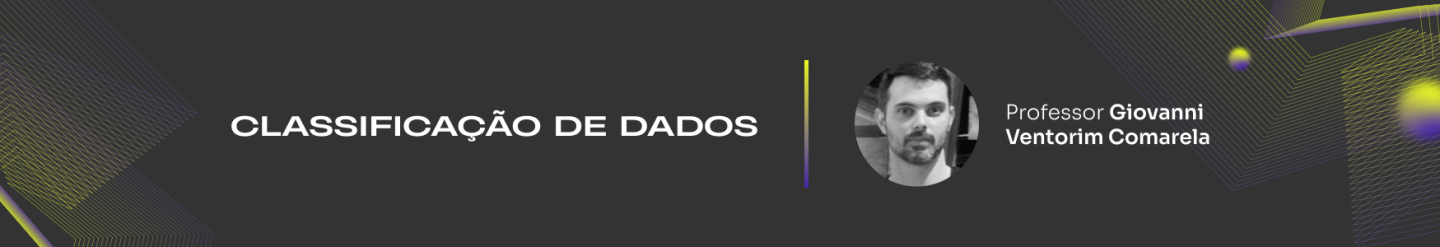

# Seleção e Importância de Características

## Nosso problema de interesse

Dados $D = \{(\mathbf{x}_i, y_i)\}_{i=1}^n$, a tarefa de classificação consiste em encontrar um modelo $f$ que aprenda dos vetores de características os rótulos.

Há dois requisitos principais:

1. Se $(\mathbf{x}, y) \in D$, então $f(\mathbf{x}) = y$ com alta probabilidade.

2. A função aprendida deve ser **generalizável**. Se um novo $\mathbf{x}$ não pertencente ao conjunto $D$ for observado, deseja-se também que $f(\mathbf{x})$ seja o rótulo correto de $\mathbf{x}$ com alta probabilidade.

## Perguntas de hoje

- Todas as características do vetor $\mathbf{x}$ são (igualmente) importantes em um problema de classificação?
- Quais são as características mais importantes?
- É possível remover algumas características e preservar o desempenho do classificador?
- Como mensurar o efeito da variação de uma característica na saída do modelo?

## Abordagem

1. Visualizações básicas
2. Técnicas para computar importância de características
3. Técnicas para selecionar características mais importantes
4. SHAP (*SHapley Additive exPlanations*) -- Interpretação

# Conjunto de dados de exemplo

Considere o conjunto de dados de exemplo apresentado abaixo.

Esse conjunto de dados é bem conhecido na literatura de aprendizado de máquina.
Cada item representa um conjunto de características de nódulos detectados em pacientes (possivelmente câncer de mama):

Além disso, os dados são anotados com o tipo de nódulo.

- Classe 1: o nódulo é benigno
- Classe 0: o nódulo é maligno

In [ ]:
from sklearn.datasets import load_breast_cancer

bc = load_breast_cancer(as_frame = True)
X, y = bc.data, bc.target

In [ ]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
print(bc.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

# Visualizações

Uma maneira simples para entender a importância de cada característica em um problema de classificação é fazer o gráfico da distribuição de cada variável para cada classe.

A seguir, tem-se a aplicação dessa ideia para o conjunto de dados de exemplo.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:453: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


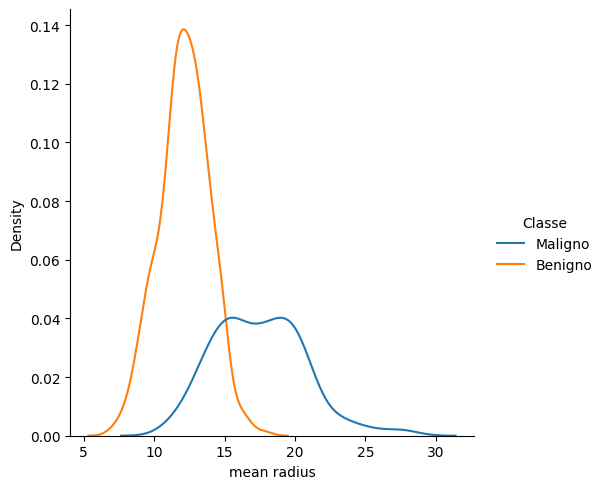

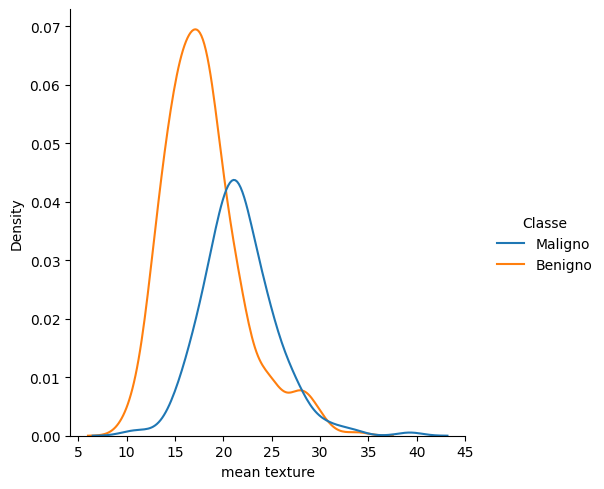

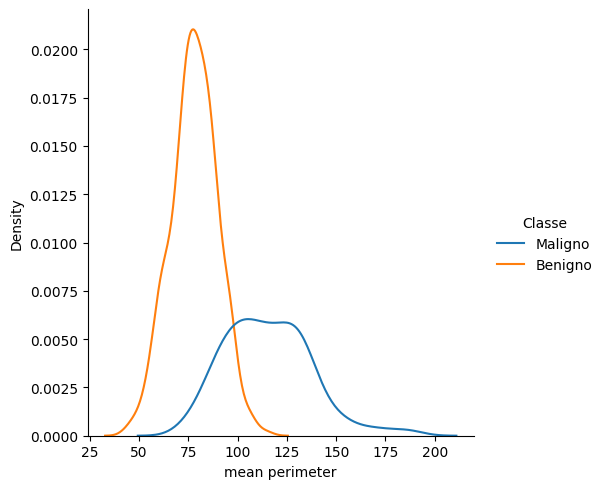

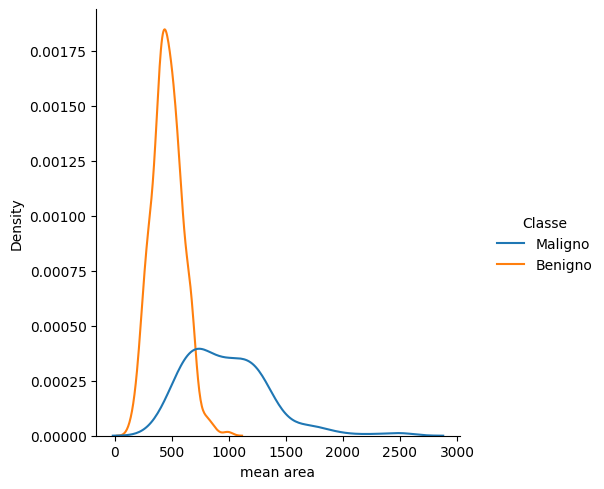

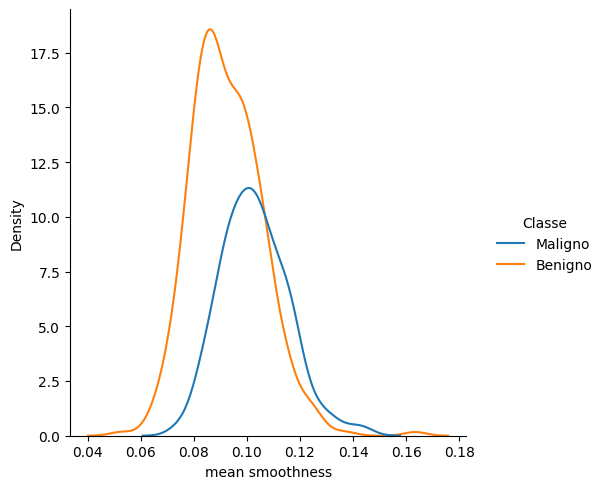

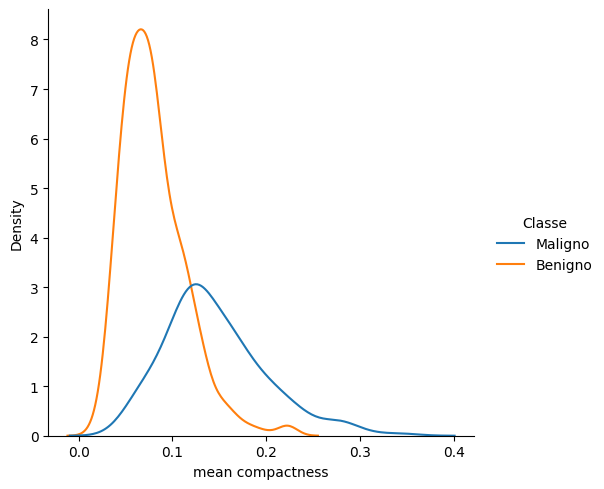

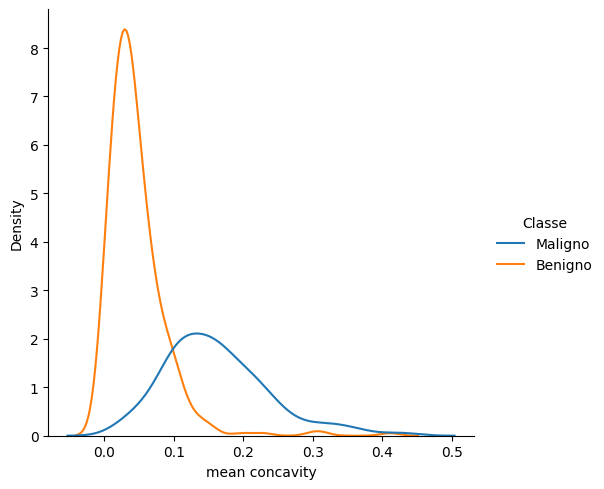

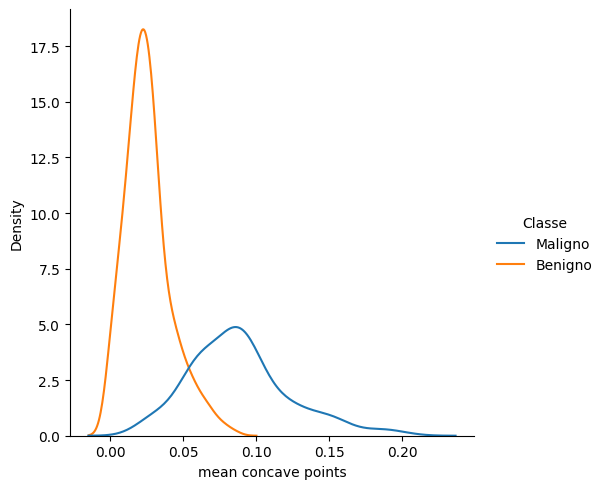

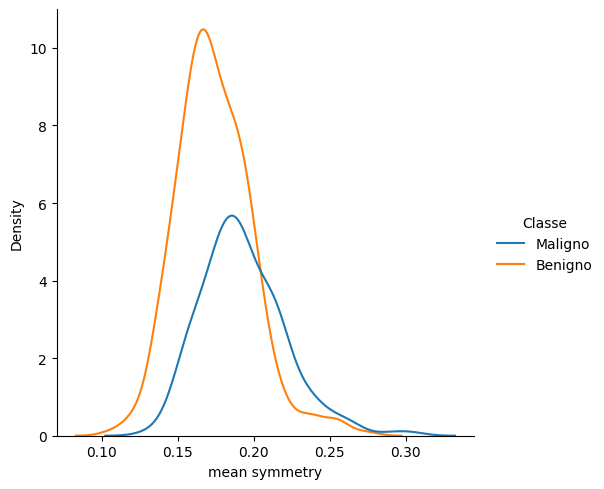

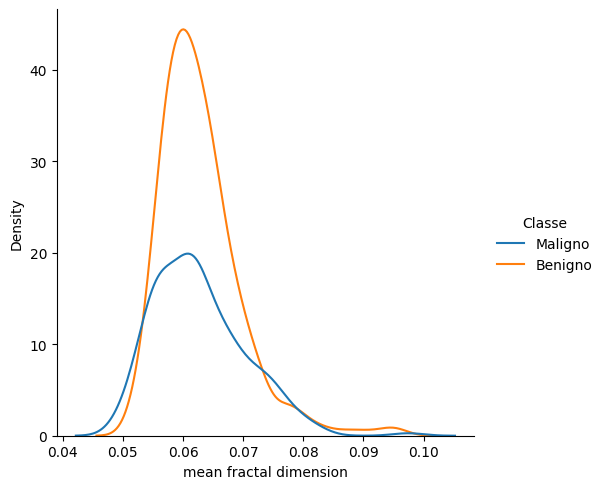

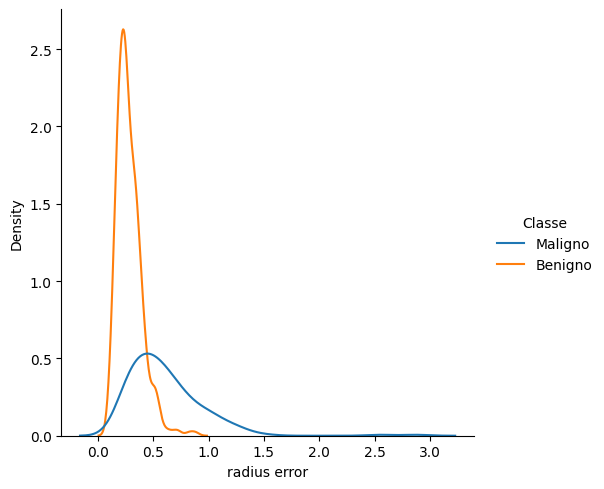

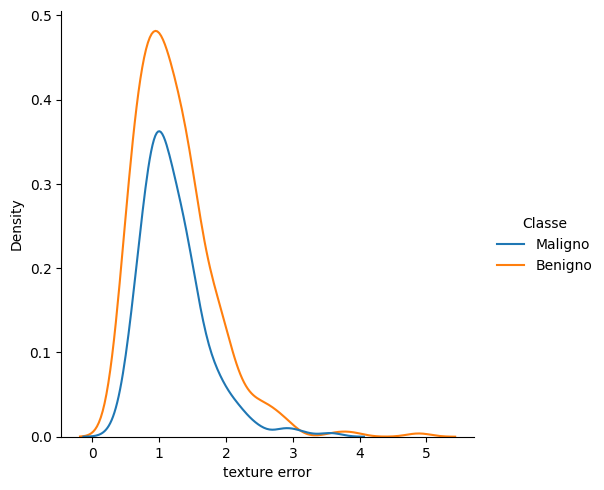

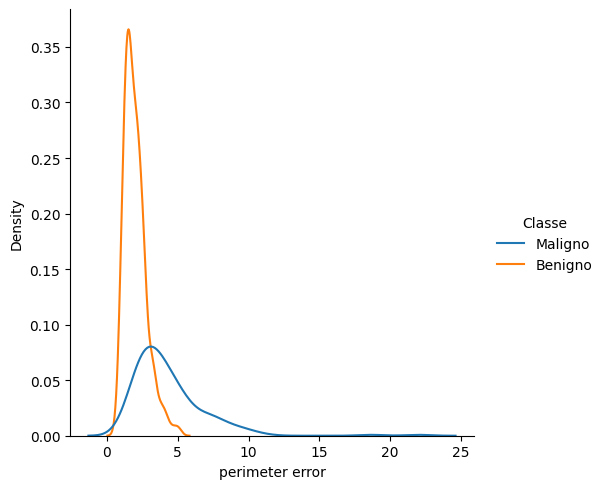

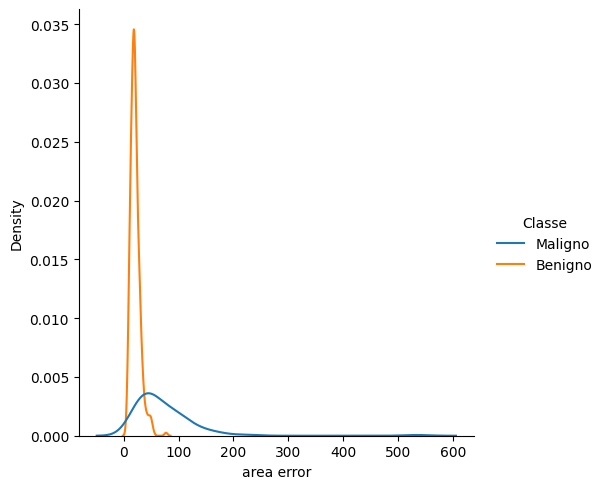

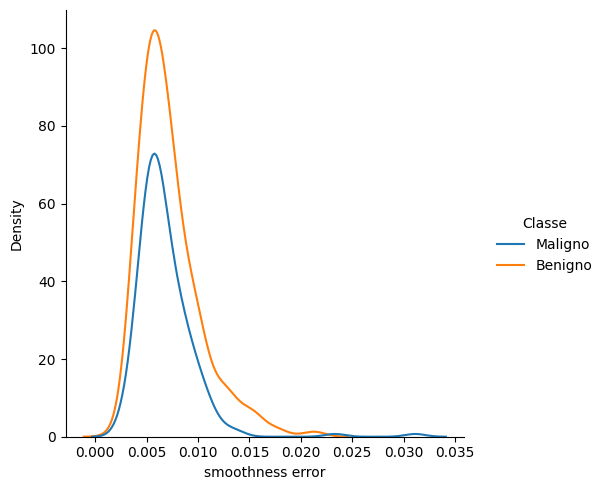

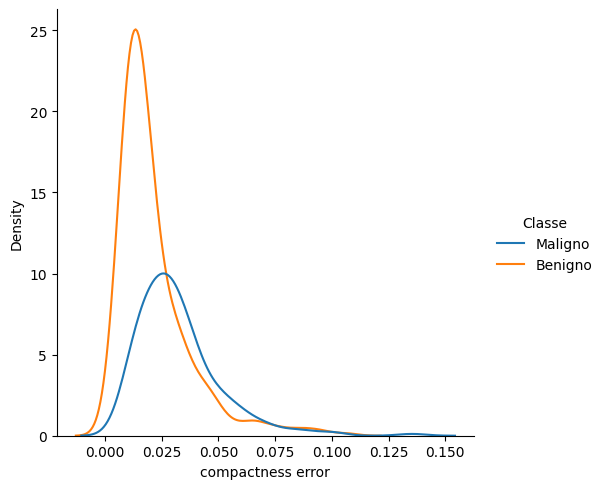

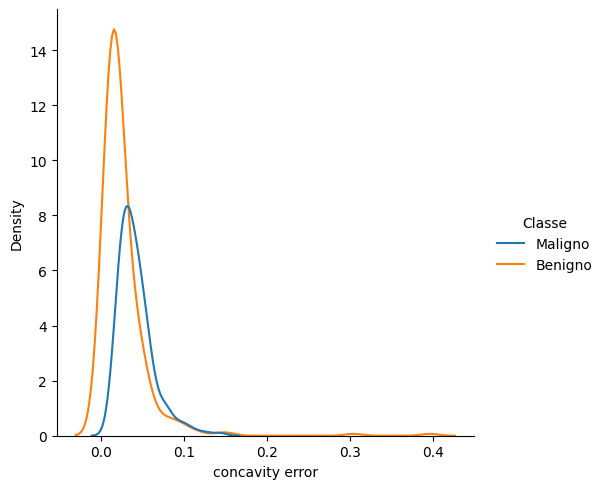

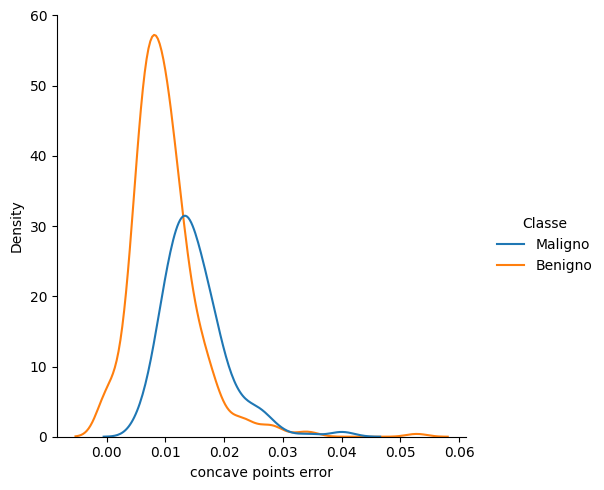

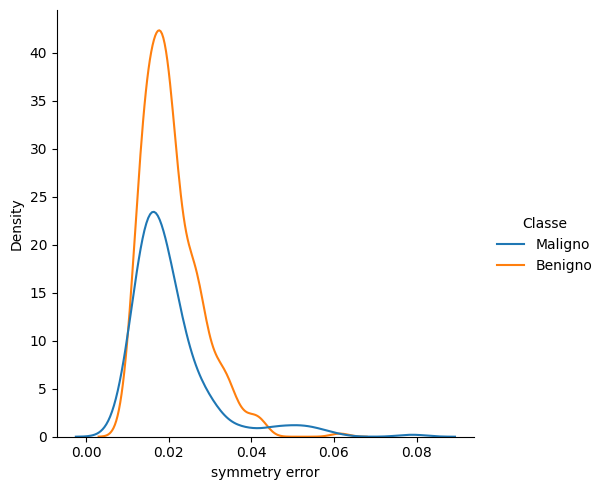

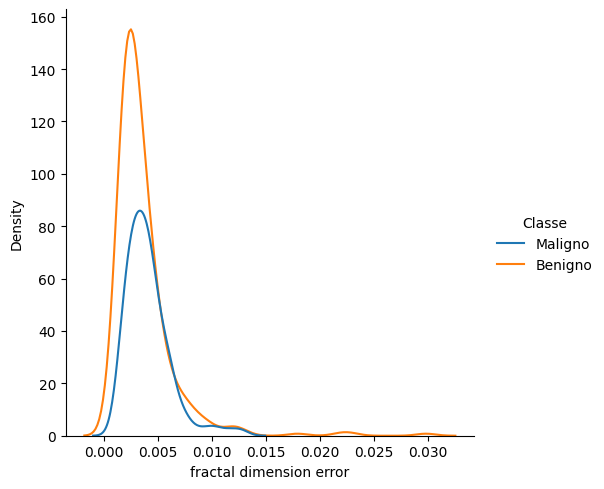

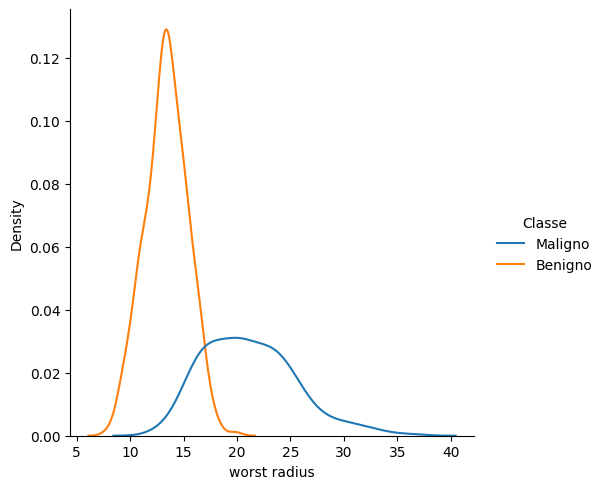

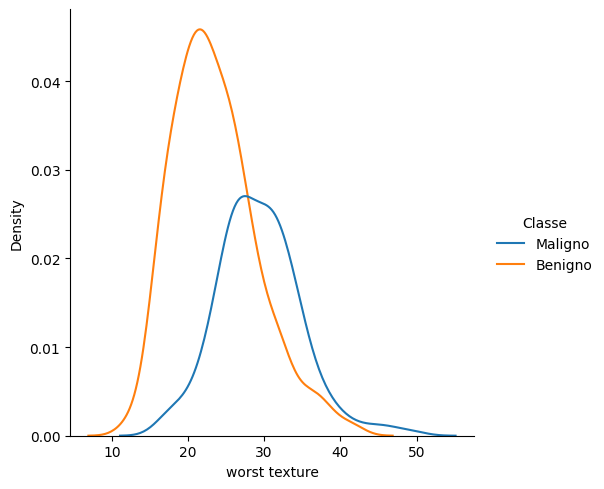

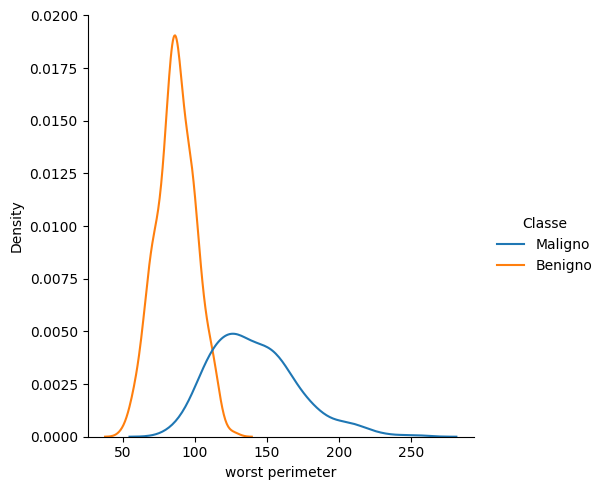

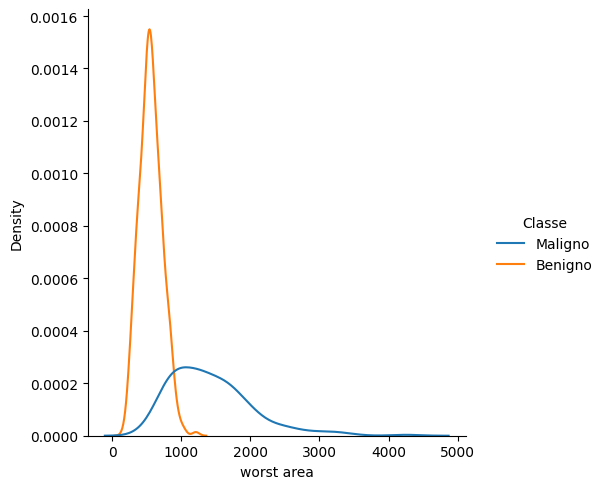

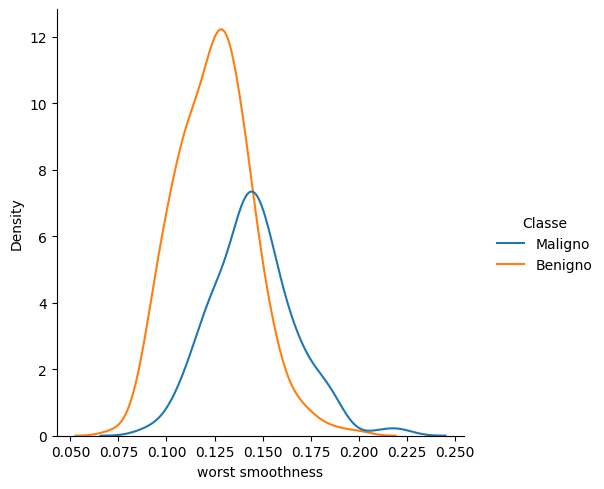

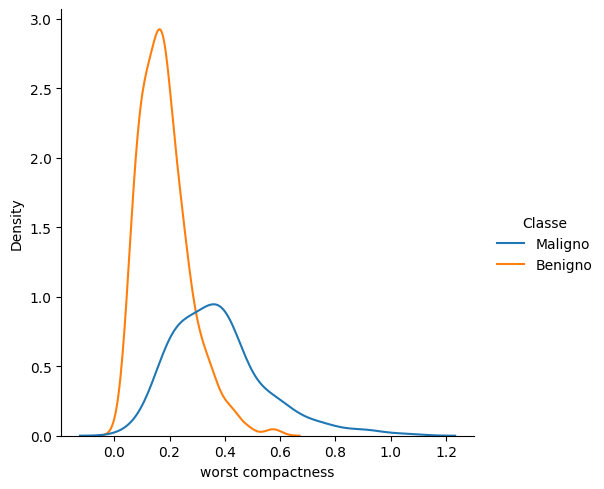

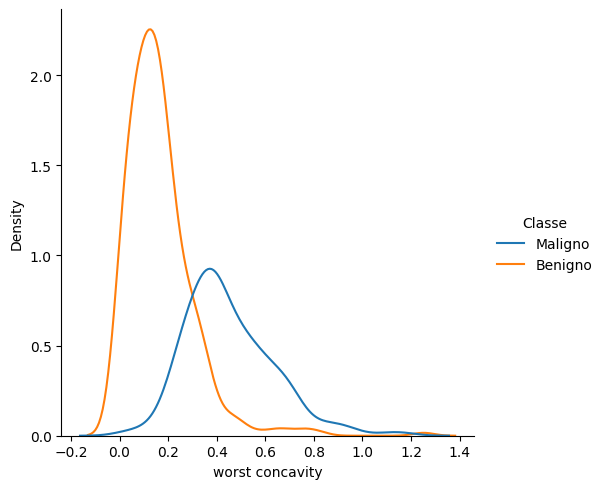

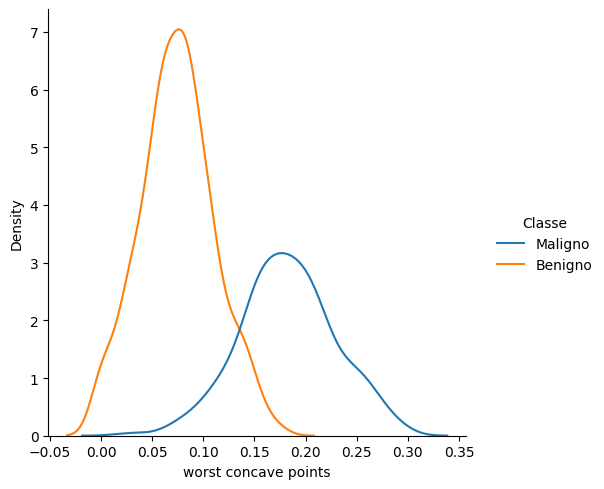

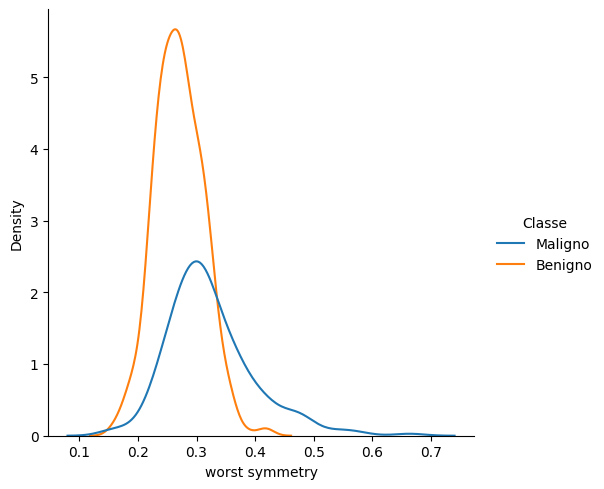

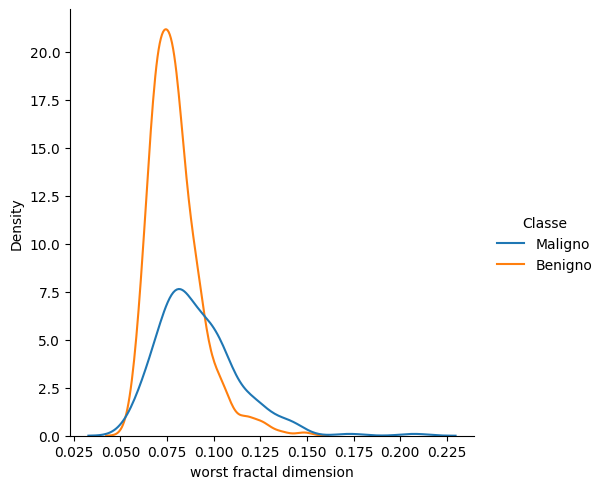

In [ ]:
import seaborn as sns

df = X.copy()
df['Classe'] = ['Maligno' if x == 0 else 'Benigno' for x in y]

for feature in X.columns:
  sns.displot(df, x = feature, hue = 'Classe', kind = 'kde');


Esse tipo de análise nem sempre é possível e não necessariamente indica quais características devem estar ou não no modelo de classificação.

A ideia é que, com esse tipo de caracterização dos dados, é possível formar uma intuição de quais características têm o potencial de contribuir com a tarefa de classificação.

# Seleção de Características (*Feature Selection*)

Após ter uma intuição que o conjunto de dados possui características com importâncias diferentes para a tarefa de classificação (como no exemplo anterior), pode-se desejar selecionar para o modelo apenas aquelas que forem essenciais.

Classicamente, há duas abordagens:

- **Abordagem univariada** - a importância de cada característica é medida individualmente; e
- **Abordagem multivariada** - a interação entre as características é considerada ao se selecionar um conjunto de características

## Abordagem univariada

Há várias abordagens para quantificar, individualmente, a importância de uma característica para um problema de classificação.

Isso pode ser feito de forma a considerar:
- Apenas o conjunto de dados de treinamento
- O conjunto de dados de treinamento e um classificador treinado (funciona apenas em alguns casos específicos)

### Informação Mútua

Uma forma clássica de mensurar a importância de características em um problema de classificação é usando o conceito de informação mútua.

#### Definição

Dadas duas variáveis aleatórias $X$ e $Y$, a informação mútua entre elas (denotada por $I(X; Y)$) mede a dependência mútua entre as duas variáveis.

Em outras palavras, $I(X; Y)$ representa a quantidade de informação que pode ser obtida sobre uma variável ao se observar a outra.

Fonte: [Wikipedia](https://en.wikipedia.org/wiki/Mutual_information).

A definição formal é ligeiramente complicada. No entanto, a informação mútua também pode ser escrita em função do conceito de entropia. Tem-se:

$$I(X; Y) = H(X) - H(X|Y),$$

onde:
- $H(X)$ é a entropia da variável aleatória $X$
- $H(X|Y)$ é a entropia condicional de $X$ dado $Y$

Lembrem, o conceito de entropia está relacionado à **quantidade de informação** necessária para descrever uma variável aleatória. Quanto maior a **incerteza** de uma variável, maior é sua entropia.

Logo (Informalmente):
- $H(X)$ representa a incerteza de $X$
- $H(X|Y)$ representa a incerteza de $X$ dado que o valor de $Y$ é conhecido

Logo, para que $I(X;Y)$ tenha um valor alto, é necessário que a incerteza de $X$ caia significativamente quando a variável $Y$ tem seu valor fixado. Em outras palavras, é necessário que $X$ tenha forte dependência em $Y$.

#### Exemplo

No contexto de classificação, podemos calcular a informação mútua entre nossa variável alvo ($y$ - rótulos/classes) e as características.

Quanto maior forem os valores observados, maior a importância de considerar a característica no modelo de classificação.

A Figura abaixo reporta os valores de informação mútua para as características  do conjunto de dados de exemplo.

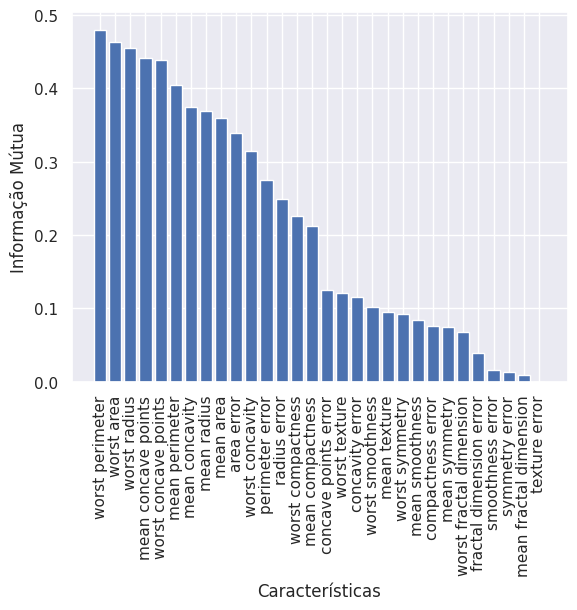

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X, y)
order = np.argsort(mi)[::-1]

plt.bar(X.columns[order], mi[order])
plt.ylabel('Informação Mútua')
plt.xlabel('Características')
plt.xticks(rotation=90);

### Importância baseada em modelos

Alguns classificadores permitem, de forma natural, o cômputo da importância de características.

Um exemplo clássico nesse sentido é o classificador baseado em Florestas Aleatórias.

Para cada árvore da floresta é calculado o quanto cada característica contribui para a elevação da pureza dos nós filhos durante construção da árvore.
Posteriormente, toma-se a média dos valores observados para cada uma das características.

Veja o exemplo abaixo para o conjunto de dados de exemplo.

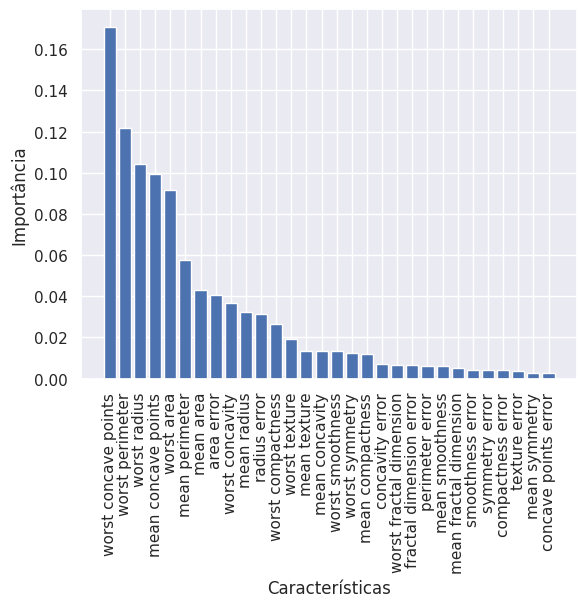

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X, y)

importances = model.feature_importances_
order = np.argsort(importances)[::-1]

plt.bar(X.columns[order], importances[order])
plt.ylabel('Importância')
plt.xlabel('Características')
plt.xticks(rotation=90);

**Observação:** nesse caso que estamos calculando a importância da característica para o modelo! Isso é diferente do que é feito com a informação mútua (que considera apenas o conjunto de dados)

### Escolhendo as $k$ características mais importantes

Suponha que seu conjunto de dados de interesse tenha uma quantidade muito grande de colunas e que você só tenha recursos computacionais para treinar um modelo com $k$ dessas características.

Dado um limite $k$ de características que podem ser utilizadas no modelo, uma estratégia imediata é escolher as $k$ características com maior informação mútua com a variável alvo (classe).

A biblioteca [`scikit-learn`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) possui uma classe para realizar tal tarefa. Veja o exemplo abaixo.

No exemplo, usa-se $k = 5$.

In [ ]:
from sklearn.feature_selection import SelectKBest

ms = SelectKBest(score_func = mutual_info_classif, k = 5)
ms.fit(X, y);

In [ ]:
ms.set_output(transform = 'pandas')
ms.transform(X)

,mean concave points,worst radius,worst perimeter,worst area,worst concave points
0,0.14710,25.380,184.60,2019.0,0.2654
1,0.07017,24.990,158.80,1956.0,0.1860
2,0.12790,23.570,152.50,1709.0,0.2430
3,0.10520,14.910,98.87,567.7,0.2575
4,0.10430,22.540,152.20,1575.0,0.1625
...,...,...,...,...,...
564,0.13890,25.450,166.10,2027.0,0.2216
565,0.09791,23.690,155.00,1731.0,0.1628
566,0.05302,18.980,126.70,1124.0,0.1418
567,0.15200,25.740,184.60,1821.0,0.2650


#### Pergunta

Faz sentido escolher $k$ características de forma independente?

Considere o exemplo abaixo. No exemplo, estamos criando duas novas características, derivadas de outras existentes, para o conjunto de dados.

Em especial, a `Característica A` e a `Característica B` foram criadas em função das características mais importantes (de acordo com a informação mútua).

In [ ]:
Z = X.copy()

Z['Característica A'] = 2 * X['worst perimeter']
Z['Característica B'] = X['worst perimeter'] + X['worst area']

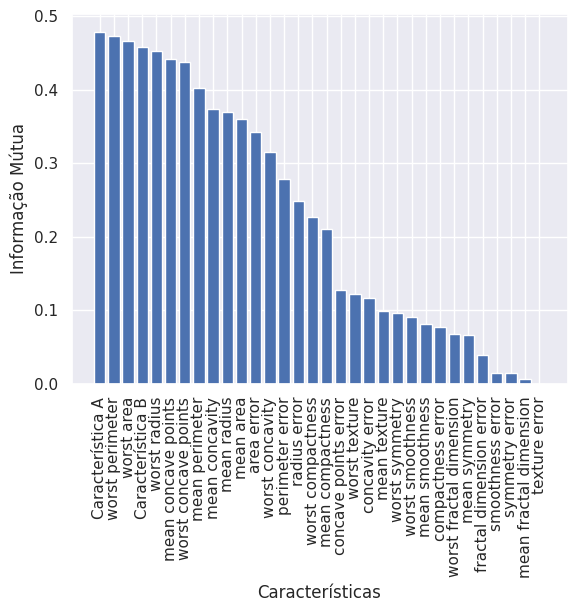

In [ ]:
mi = mutual_info_classif(Z, y)

order = np.argsort(mi)[::-1]
plt.bar(Z.columns[order], mi[order])
plt.ylabel('Informação Mútua')
plt.xlabel('Características')
plt.xticks(rotation=90);

Como consequência da forma como foram criadas, as características criadas também são importantes para o problema de classificação.

Assim, o resultado do gráfico ainda faz sentido, mas veja que as novas características computadas não adicionam **nova** informação ao conjunto de dados.

Logo, se fôssemos escolher as 5 características mais importantes do novo conjunto de dados, estaríamos, selecionando características com informações redundantes.

Assim, escolher as $k$ melhores características **individualmente** pode não ser a melhor abordagem.

## Abordagem multivariada

Dado um inteiro $k$ e um problema de classificação, qual o melhor conjunto $S$, de tamanho $k$, de características para construir um classificador?

Em outras palavras, se só pudermos treinar um modelo em $k$ características, quais deveríamos escolher?

Nos exemplos acima, vimos que fazer uma escolha com base nas importâncias individuais pode não ser uma abordagem adequada.

Uma escolha ótima torna-se, pelo que se sabe até o momento, intratável, uma vez que existem ${d \choose k}$ subconjuntos de tamanho $k$ para um total de $d$ características.

Há dois conjuntos clássicos de heurísticas para abordar o problema:
1. Eliminação Recursiva de Características (RFE -- *Recursive Feature Elimination*);
2. Seleção Sequencial de Características (SFE -- *Sequential Feature Selection*).

O primeiro funciona apenas em um contexto mais restrito/simples. O segundo conjunto é de propósito mais geral, o qual vamos explorar em mais detalhes.

### Seleção Sequencial de Características

**Entrada**

- Um conjunto de dados de treinamento $D = \{(\mathbf{x}_i, y_i)\}_{i = 1}^n$. Os vetores de características possuem $d$ características
- Um inteiro $k$. Tamanho do conjunto reduzido de características ($k \le d$)
- Um algoritmos de aprendizado $\mathcal{A}$

**Algoritmo**

1. $S = \emptyset$
2. **While** $|S| < k$ **do**
3.   > Encontre a característica $s$ que maximize o score (e.g., acurácia ou $F_1$-score - via validação cruzada) quando $\mathcal{A}$ é treinado com as características em $S\cup \{s\}$
  
4.   > $S ← S \cup \{s\}$
  
5.  return $S$

O algoritmo acima não é ótimo, ou seja, ele não garante que o melhor conjunto $S$ será selecionado. No entanto, é uma heurística razoável (do ponto de eficiência algorítmica e desempenho do classificador gerado) e comum de ser utilizada na prática.

Abaixo, um exemplo de como utilizar a metodologia na [`scikit-learn`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html). No exemplo, utiliza-se $k = 5$ características.




In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 50)

sfs = SequentialFeatureSelector(model, n_features_to_select = 5)
sfs.set_output(transform = 'pandas')
sfs.fit(X, y);

In [ ]:
sfs.transform(X)

,radius error,smoothness error,worst texture,worst perimeter,worst smoothness
0,1.0950,0.006399,17.33,184.60,0.16220
1,0.5435,0.005225,23.41,158.80,0.12380
2,0.7456,0.006150,25.53,152.50,0.14440
3,0.4956,0.009110,26.50,98.87,0.20980
4,0.7572,0.011490,16.67,152.20,0.13740
...,...,...,...,...,...
564,1.1760,0.010300,26.40,166.10,0.14100
565,0.7655,0.005769,38.25,155.00,0.11660
566,0.4564,0.005903,34.12,126.70,0.11390
567,0.7260,0.006522,39.42,184.60,0.16500


## Informação Mútua vs. Seleção Sequencial de Características

Vamos agora conduzir um experimento simples, comparando modelos obtidos com as características selecionadas com as técnicas:
- Univariada - $k$ características com maior informação mútua com a variável alvo; e
- Multivariada - $k$ características selecionadas utilizando a Seleção Sequencial de Características.

Escolhendo um valor para $k$

In [ ]:
k = 5

Dividindo os dados em conjuntos de treino e teste

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size = 0.33)

Selecionando as $k$ características de maior informação mútua.

In [ ]:
from sklearn.feature_selection import SelectKBest

skb = SelectKBest(score_func = mutual_info_classif, k = k)
skb.fit(X_train, y_train);

model = RandomForestClassifier()
model.fit(skb.transform(X_train), y_train)

y_pred = model.predict(skb.transform(X_test))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91        71
           1       0.96      0.92      0.94       117

    accuracy                           0.93       188
   macro avg       0.92      0.93      0.93       188
weighted avg       0.93      0.93      0.93       188



In [ ]:
skb.set_output(transform = 'pandas')
skb.transform(X_train).head(2)

,worst radius,worst perimeter,worst area,Característica A,Característica B
365,24.310,161.20,1780.0,322.40,1941.20
46,8.964,57.26,242.2,114.52,299.46


Selecionando as características.

In [ ]:
sfs = SequentialFeatureSelector(RandomForestClassifier(n_estimators = 50), n_features_to_select = k)
sfs.fit(X_train, y_train);

model = RandomForestClassifier()
model.fit(sfs.transform(X_train), y_train)

y_pred = model.predict(sfs.transform(X_test))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        71
           1       0.98      0.98      0.98       117

    accuracy                           0.98       188
   macro avg       0.98      0.98      0.98       188
weighted avg       0.98      0.98      0.98       188



In [ ]:
sfs.set_output(transform = 'pandas')
sfs.transform(X_train).head(2)

,area error,compactness error,worst texture,worst concave points,Característica B
365,72.440,0.01906,26.37,0.17650,1941.20
46,8.205,0.01646,21.96,0.02564,299.46


No caso do exemplo em questão, a seleção sequencial de características conseguiu identificar 5 características que propiciaram a criação de um modelo melhor do que a seleção individual de características baseada em informação mútua.

## Como definir o $k$?

Acho que essa pergunta está nos assombrando...

Resposta simples: $k$ é um hiperparâmetro e pode/deve ser escolhido via validação cruzada! Veja um exemplo na documentação da  [`scikit-learn`](https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html#sphx-glr-auto-examples-compose-plot-compare-reduction-py).

# Interpretação de modelos

O que vimos até agora nos ajuda a encontrar características interessantes para um problema de classificação. Também nos ajuda a reduzir a complexidade dos dados sem perder muito em desempenho do modelo.

No entanto, o que vimos até agora não nos permite interpretar um modelo de classificação. Em outras palavras, se o valor de uma característica aumenta/diminui, isso tende ter um efeito significativo na saída do modelo?

Responder essa pergunta é uma tarefa não trivial no mundo de classificação.

Recentemente, foi proposta uma abordagem baseada em teoria dos jogos, que está encapsulada na biblioteca [SHAP](https://shap.readthedocs.io/).

Infelizmente, nessa disciplina nós não temos o conhecimento básico necessário para entender como a metodologia funciona. Mas, vamos ver alguns exemplos de ferramentas da biblioteca e como interpretar alguns gráficos.

[Vídeo](https://www.youtube.com/watch?v=2xlgOu22YgE) interessante explicando alguns gráficos.

## Valores SHAP

Valores SHAP representam a contribuição do valor de uma característica para a predição realizada por um modelo.

Vamos discutir brevemente dois gráficos disponibilizados pela biblioteca. Mais exemplos, detalhes e explicações [aqui](https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability)

Instalando a biblioteca (ela não é padrão em alguns sistemas)

In [ ]:
!pip install shap

Dividindo o conjunto de dados em porções para treinamento e teste.

In [ ]:
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

Treinando uma Floresta Aleatória com 100 árvores.

In [ ]:
model = RandomForestClassifier(n_estimators = 100)
model.fit(X_train, y_train);

Testando e avaliando o modelo no conjunto de teste.

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96        74
           1       0.98      0.96      0.97       114

    accuracy                           0.97       188
   macro avg       0.96      0.97      0.97       188
weighted avg       0.97      0.97      0.97       188



Obtendo os valores SHAP.

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)[:,:,1]

Obtendo o gráfico *Beeswarm*

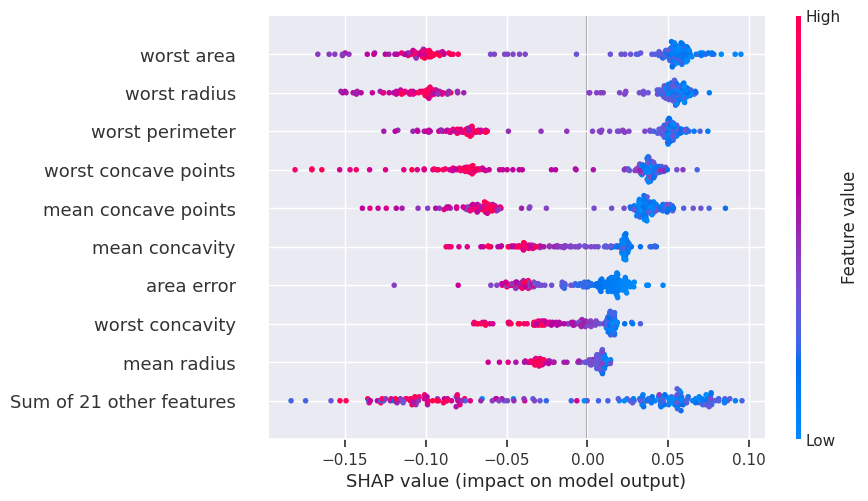

In [ ]:
shap.plots.beeswarm(shap_values)

Como interpretar o gráfico acima? Ele possui vários pontos importantes:
- No eixo $Y$, temos todas as características ordenadas em ordem decrescente de importância;
- Para cada característica, cada ponto do gráfico representa uma instância do conjunto de teste.
- No eixo $X$, temos o valor SHAP. Para uma característica, um ponto com valor SHAP positivo indica uma contribuição para que o modelo tenha a Classe 1 como saída. Reciprocamente, um valor negativo de SHAP indica contribuição para a Classe 0.
- A cor dos pontos indica o valor para a característica que o elemento correspondente ao ponto do gráfico possui.


No caso do gráfico acima, temos, por exemplo, que:
- Para a característica `worst perimeter` (assim como as demais), um valor alto da característica tende a levar o modelo a ter a Classe 0 (nódulo maligno) como saída.

Em resumo, valores SHAP são úteis para interpretar o funcionamento do modelo.
Nesse sentido, é importante lembrar que o valor SHAP é **referente ao comportamento do modelo** e não ao conjunto de dados em si.